# TP2: Regresión del valor de valor medio de casas en distritos de California (17Co2024)

GitHub: https://github.com/adrianlapaz3/AII_course

## ADRIÁN LAPAZ
## JULIAN SALAS

### Regresión del valor de valor medio de casas en distritos de California
Se requiere construir una regresión que nos permita predecir el valor medio de las casas en distritos de California, EEUU (medidos en cientos de miles de dólares $100,000). Este dataset se deriva del censo de 1990 de EEUU, donde cada observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EEUU publica datos de muestra (un bloque típicamente tiene una población de 600 a 3000 personas).

Los atributos, en el orden en que se guardaron en el dataset, son:

**MedInc:** Ingreso medio en el bloque\
**HouseAge:** Edad mediana de las casas en el bloque\
**AveRooms:** Número promedio de habitaciones por hogar.\
**AveBedrms:** Número promedio de dormitorios por hogar.\
**Population:** Población del bloque\
**AveOccup:** Número promedio de miembros por hogar.\
**Latitude:** Latitud del bloque\
**Longitude:** Longitud del bloque

Y el target es:

**MedHouseVal:** Mediana del costo de casas en el bloque (en unidades de a $100.000)

### Tareas y preguntas a resolver:

1. Obtener la correlación entre los atributos y los atributos con el target. ¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí? Se puede obtener los valores o directamente graficar usando un mapa de calor.
2. Graficar los histogramas de los diferentes atributos y el target. ¿Qué tipo de forma de histograma se observa? ¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?
3. Calcular la regresión lineal usando todos los atributos. Con el set de entrenamiento, calcular la varianza total del modelo y la que es explicada con el modelo. ¿El modelo está capturando el comportamiento del target? Expanda su respuesta.
4. Calcular las métricas de MSE, MAE y R2 del set de evaluación.
5. Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α
6. Comparar, entre la regresión lineal y la mejor regresión de Ridge, los resultados obtenidos en el set de evaluación. ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?

El entregable consiste en uno o más archivos de notebook ipynb con las respuestas. Aunque se da libertad para usar otros tipos de entregables, es importante incluir tanto el código de lo resuelto como las respuestas. Pueden subir el contenido o proporcionar un enlace a un repositorio público (GitHub o GitLab) con el contenido. **No olviden especificar los autores del TP en el entregable**.

Para resolver este TP, son libres de utilizar los recursos que consideren necesarios. Pueden hacerlo en cualquier lenguaje de programación y de la forma que consideren apropiada.

### Punto 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

sns.set()

In [2]:
# Leemos el dataset
california_housing = fetch_california_housing()

# Y obtenemos los atributos y target
X = california_housing.data
y = california_housing.target

# Transformamos en Pandas
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos a X e y, esto ayuda a la parte de la gráfica del mapa de calor de correlación
df_california = pd.concat([X, y], axis=1)

In [3]:
# Como es un analisis estadístico y no geoestadístico, latitude y longuitude no deberían incluirse
df_california = df_california.drop(['Latitude','Longitude'], axis=1)
df_california.head(5)

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  MedHouseVal
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556        4.526
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842        3.585
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260        3.521
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945        3.413
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467        3.422

In [4]:
# Calculcar los máximos y mínimos de cada variable

import pandas as pd

# Calcular las estadísticas requeridas
Mínimo = df_california.min().round(2)
Media = df_california.mean().round(2)
Mediana = df_california.median().round(2)
Desvío_Estándar = df_california.std().round(2)
Q1 = df_california.quantile(0.25).round(2) # El Cuartil 1 (Q1) es el valor que separa el 25% inferior 
                                           # de los datos de un conjunto ordenado.
Q3 = df_california.quantile(0.75).round(2) # El Cuartil 3 (Q3) es el valor que separa el 75% inferior 
                                           # de los datos de un conjunto ordenado.
IQR = Q3 - Q1 # rango intercuartílico (IQR, InterQuartile Range)
Límite_Inferior = (Q1 - 1.5 * IQR).round(2)
Límite_Superior = (Q3 + 1.5 * IQR).round(2)

# Crear el DataFrame con las estadísticas
stats_summary = pd.DataFrame({
    'Mínimo': Mínimo,
    'Media': Media,
    'Mediana': Mediana,
    'Desvío Estándar': Desvío_Estándar,
    'Q1': Q1,
    'Q3': Q3,
    'Límite Inferior': Límite_Inferior,
    'Límite Superior': Límite_Superior
})

# Mostrar la tabla resultante
stats_summary.T

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
Mínimo             0.50      1.00      0.85       0.33        3.00      0.69   
Media              3.87     28.64      5.43       1.10     1425.48      3.07   
Mediana            3.53     29.00      5.23       1.05     1166.00      2.82   
Desvío Estándar    1.90     12.59      2.47       0.47     1132.46     10.39   
Q1                 2.56     18.00      4.44       1.01      787.00      2.43   
Q3                 4.74     37.00      6.05       1.10     1725.00      3.28   
Límite Inferior   -0.71    -10.50      2.03       0.87     -620.00      1.16   
Límite Superior    8.01     65.50      8.46       1.24     3132.00      4.56   

                 MedHouseVal  
Mínimo                  0.15  
Media                   2.07  
Mediana                 1.80  
Desvío Estándar         1.15  
Q1                      1.20  
Q3                      2.65  
Límite Inferior        -0.97  
Límite Superior         4.82

Antes de los análisis, es importante excluir outliers, definidos como valores menores a Q1 - 1.5\*IQR o mayores a Q3 + 1.5\*IQR. El rango intercuartílico o IQR por sus siglas en inglés (*"Interquartile Range"*) se calcula como la diferencia entre el quartil tres y uno (Q3 - Q1).

In [5]:
df_filtered = df_california.copy()

# Aplicar el filtro para cada columna
for column in df_filtered.columns:
    Q1 = df_filtered[column].quantile(0.25)
    Q3 = df_filtered[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar los datos que están dentro de los límites
    df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]

# Mostrar el DataFrame filtrado
df_filtered.head()


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  MedHouseVal
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945        3.413
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467        3.422
5  4.0368      52.0  4.761658   1.103627       413.0  2.139896        2.697
6  3.6591      52.0  4.931907   0.951362      1094.0  2.128405        2.992
7  3.1200      52.0  4.797527   1.061824      1157.0  1.788253        2.414

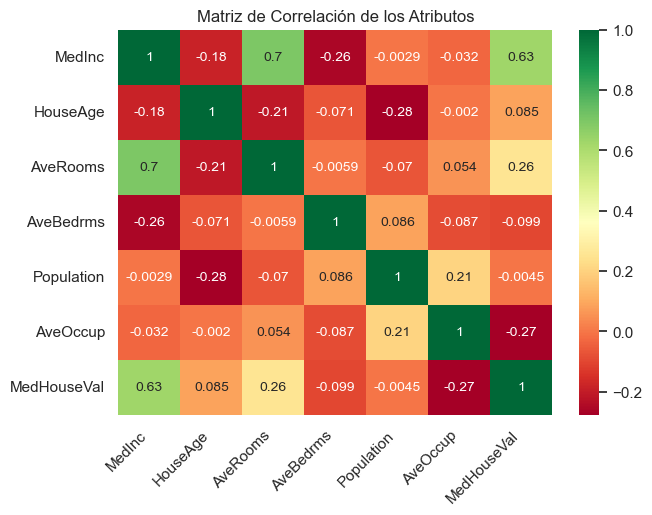

In [6]:
# Correlación entre los atributos y los atributos con el targe
plt.figure(figsize=(7, 5))
correlacion = np.corrcoef(df_filtered.values.T)
sns.heatmap(data=correlacion, annot=True, annot_kws={"size": 10}, cmap="RdYlGn",
            xticklabels=df_filtered.columns, yticklabels=df_filtered.columns)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Matriz de Correlación de los Atributos')
plt.show()
plt.show()

In [7]:
# Calcular la correlación de Pearson en valores abosulto de cada atributo con el target
correlacion_target = df_filtered.corr()['MedHouseVal'].drop(labels=['MedHouseVal']).abs().sort_values(ascending=False).round(3)

print("Correlación absoluta de los atributos con el target 'MedHouseVal':")
print(correlacion_target)


Correlación absoluta de los atributos con el target 'MedHouseVal':
MedInc        0.631
AveOccup      0.275
AveRooms      0.257
AveBedrms     0.099
HouseAge      0.085
Population    0.005
Name: MedHouseVal, dtype: float64


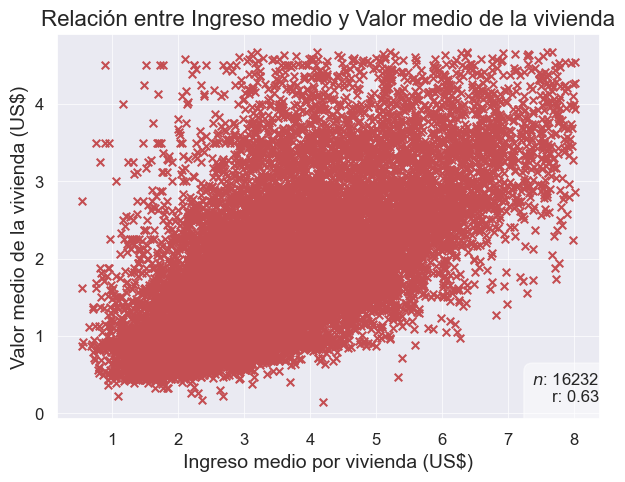

In [8]:
# Gráfica de la correlación de Pearson entre 'MedInc' y 'MedHouseVal'
cor_MedInc_target = np.corrcoef(df_filtered['MedInc'], df_filtered['MedHouseVal'])[0, 1]

# Graficar el dataset
plt.figure(figsize=(7, 5))
plt.scatter(df_filtered['MedInc'], df_filtered['MedHouseVal'], color='r', marker="x", s=30)
plt.grid(True, linewidth=0.5)
plt.xlabel('Ingreso medio por vivienda (US$)', fontsize=14)
#plt.xlim(0,16)
plt.ylabel('Valor medio de la vivienda (US$)', fontsize=14)
#plt.ylim(0,6)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title('Relación entre Ingreso medio y Valor medio de la vivienda', fontsize=16)

n = len(df_filtered)

# Agregar la correlación de Pearson como texto dentro de la gráfica
plt.text(1, 0, f'$n$: {n}\nr: {cor_MedInc_target:.2f}\n', 
         fontsize=12, ha='right', va='baseline', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.show()


**¿Cuál atributo tiene mayor correlación lineal con el target y cuáles atributos parecen estar más correlacionados entre sí?** \
El atributo más fuertemente correlacionado con el valor medio de la vivienda (*'MedHouseVal'*) es el ingreso medio por vivienda *'MedInc'*. Según el ranking de correlaciones absolutas, el mapa de calor y la gráfica del valor medio de la vivienda en función del ingreso medio por vivienda, la relación es positiva moderada a fuerte según el valor de 0.63 de correlación de Pearson observado. Esto, sugiere que a medida que el ingreso medio en un bloque aumenta, el valor medio de las viviendas también tiende a aumentar. Además, esta correlación no es spuria ya que es lógico esperar que las zonas con ingresos más altos tengan viviendas más caras y viceversa.

### Punto 2

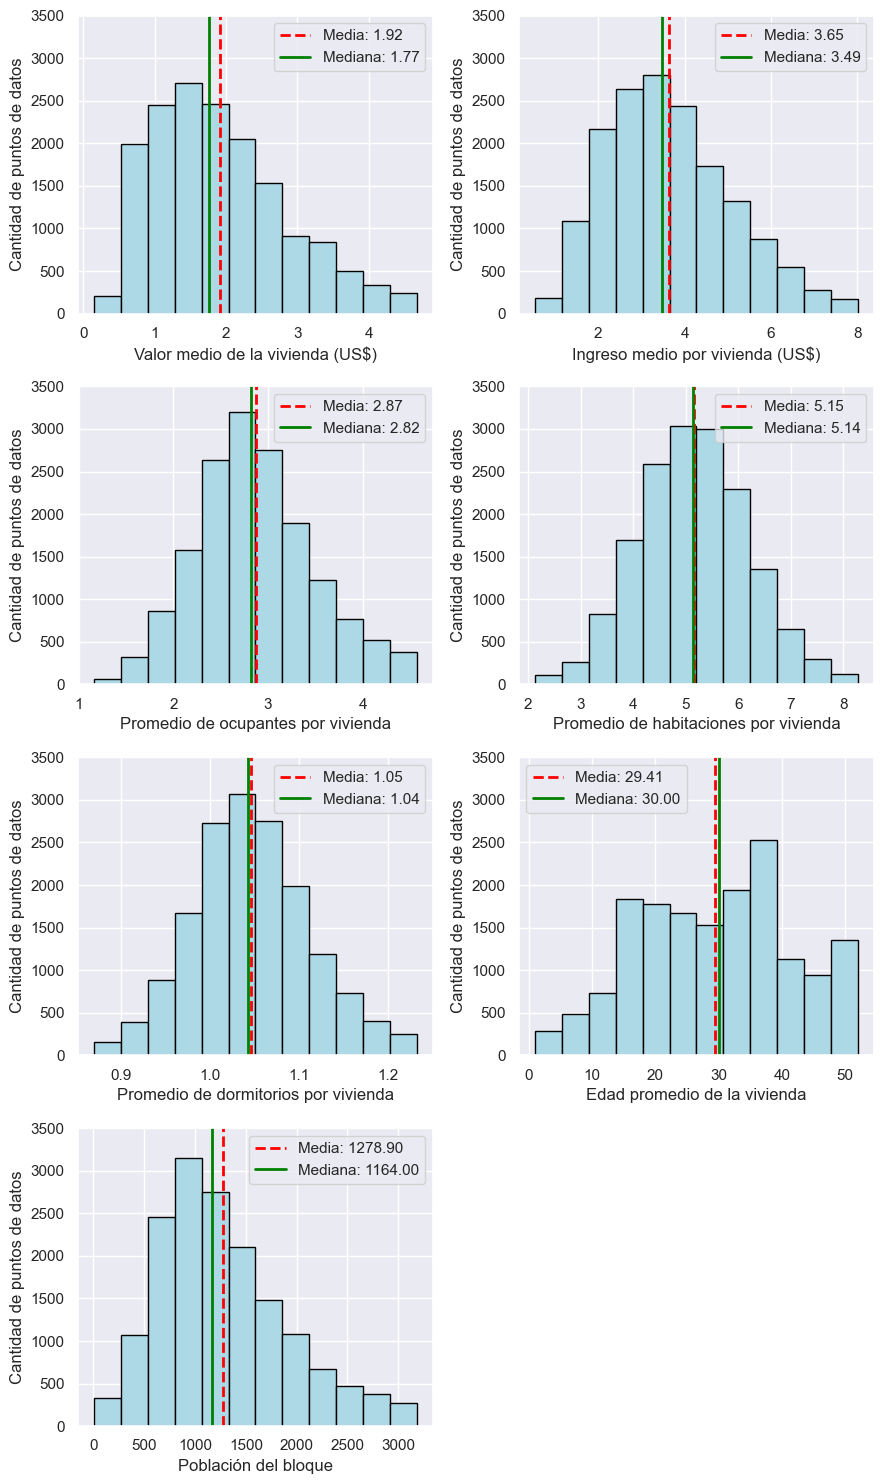

In [9]:
import matplotlib.pyplot as plt

# Diccionario para los nombres en español y sus unidades de las variables
variables = {
    "MedHouseVal": ("Valor medio de la vivienda (US$)"),
    "MedInc": ("Ingreso medio por vivienda (US$)"),
    "AveOccup": ("Promedio de ocupantes por vivienda"),
    "AveRooms": ("Promedio de habitaciones por vivienda"),
    "AveBedrms": ("Promedio de dormitorios por vivienda"),
    "HouseAge": ("Edad promedio de la vivienda"),
    "Population": ("Población del bloque")   
}

# Crear la figura con un layout 3x3
plt.figure(figsize=(9, 15))

# Graficar los histogramas para cada variable
for i, (var, name_es) in enumerate(variables.items()):
    plt.subplot(4, 2, i + 1)
    df_filtered[var].hist(bins=12, color='lightblue', edgecolor='black')
    
    # Calcular la media y la mediana
    media = df_filtered[var].mean()
    mediana = df_filtered[var].median()
    
    # Agregar líneas verticales para la media y la mediana
    plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media: {media:.2f}')
    plt.axvline(mediana, color='green', linestyle='-', linewidth=2, label=f'Mediana: {mediana:.2f}')
    
    # Etiquetas de los ejes
    plt.xlabel(f"{name_es}", fontsize=12)
    plt.ylabel('Cantidad de puntos de datos', fontsize=12)
    plt.ylim(0,3500)
    
    # Mostrar la leyenda
    plt.legend()

plt.tight_layout()
plt.show()


1. **¿Qué tipo de forma de histograma se observa?** \
Observando los histogramas presentados, podemos identificar varios patrones distintos:\
*Valor medio de la vivienda (US\$)* e *Ingreso medio por vivienda (US\$)*: Estas distribuciones tienen una ligera asimetría positiva. Aunque tienen una forma algo similar a una campana, presentan una cola extendida hacia la derecha, lo que indica que hay valores atípicos elevados en el conjunto de datos. Esta asimetría sugiere que estas distribuciones no son perfectamente normales, sino que tienden hacia una forma sesgada a la derecha.\
*Promedio de ocupantes por vivienda*, *Promedio de habitaciones por vivienda*, y *Promedio de dormitorios por vivienda*: Estas distribuciones parecen ser más simétricas y se aproximan más a una forma de campana, lo cual es característico de una distribución normal. No obstante, no son perfectamente simétricas, lo que indica que, aunque se asemejan a una distribución normal, puede haber cierta desviación.\
*Edad promedio de la vivienda*: Esta distribución muestra una clara asimetría negativa (sesgo a la izquierda). Aquí, la cola de la distribución se extiende hacia valores más bajos, lo que sugiere que la mayoría de las viviendas tienen una edad más alta con pocas viviendas más nuevas. Este tipo de distribución no es en absoluto normal.\
*Población del bloque*: Esta distribución tiene una marcada asimetría positiva con una cola larga hacia la derecha. La mayor concentración de datos está en los bloques con menor población, con una pequeña cantidad de bloques que tienen una población significativamente mayor. Esta distribución es claramente no normal y está más cercana a una distribución exponencial o gamma.

2. **¿Se observa alguna forma de campana que nos indique que los datos pueden provenir de una distribución gaussiana, sin entrar en pruebas de hipótesis?** \
Sí, algunas de las variables muestran distribuciones que se asemejan a una forma de campana, lo cual podría sugerir, de manera preliminar, que los datos provienen de una distribución gaussiana. Sin embargo, es importante señalar que:\
*Promedio de ocupantes por vivienda*, *Promedio de habitaciones por vivienda*, y *Promedio de dormitorios por vivienda*: Estas variables son las que más se acercan a una distribución normal, ya que presentan una simetría relativamente alta y la media y la mediana están muy cerca. La forma de campana observada en estos histogramas podría ser indicativa de una distribución normal.\
*Valor medio de la vivienda (US\$)* y *Ingreso medio por vivienda (US\$):* Aunque estas distribuciones muestran una forma de campana, la asimetría positiva sugiere que podrían no ser perfectamente normales. Sin embargo, en un análisis preliminar y sin realizar pruebas formales de hipótesis, podríamos decir que podrían aproximarse a una distribución normal, pero con reservas.\
*Edad promedio de la vivienda* y *Población del bloque*: Estas no muestran una forma de campana, y debido a su asimetría, es improbable que sigan una distribución gaussiana. Estas variables parecen estar mejor descritas por distribuciones asimétricas, como la gamma o exponencial.

**Conclusión:**
En resumen, solo las variables relacionadas con el promedio de ocupantes, habitaciones, y dormitorios muestran una forma que sugiere una distribución normal, mientras que las otras variables muestran asimetrías que indican desviaciones significativas de la normalidad. Para una evaluación más rigurosa, sería necesario realizar pruebas de normalidad, pero visualmente, esta es la interpretación preliminar. Como sugerencias, en éste caso como las el número de puntos es mayor a 50, se debería aplicar el test de *Kolmogorov-Smirnov* para determinar si hay normalidad en las variables.


# Punto 3

### Concepto de Modelo Lineal

Un modelo lineal se define como una relación entre una variable dependiente ($y$= y una o más variables independientes ($X$), expresada mediante una ecuación lineal. Esta ecuación tiene la forma:

$y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p + e$

Donde:
- $\beta_0$ es la intersección o término constante.
- $\beta_1, \beta_2, \dots, \beta_p$ son los coeficientes asociados a las variables independientes $X_1, X_2, \dots, X_p$.
- $e$ representa el término de error, que captura las variaciones impredecibles y los factores no incluidos en el modelo.

El objetivo principal de un modelo lineal es ajustar una línea recta que minimice la suma de los cuadrados de las diferencias entre los valores observados y los valores predichos (esto es, minimizar los residuos). Este modelo se basa en el supuesto de que la relación entre las variables dependientes e independientes es lineal.


### Ajuste de un modelo lineal 

Para ajustar un modelo lineal multivariado se realizá una metodología que consistirá en:
1. **Partición de los datos:** Los datos se dividirán en un conjunto de entrenamiento (70% del total) para ajustar el modelo y un conjunto de prueba (30% restante) para evaluar la capacidad predictiva del modelo.
2. **Eliminación de variables independientes correlacionadas:** Se identificarán y eliminarán aquellas variables independientes que presenten un coeficiente de correlación de Pearson superior a 0.5 en valor absoluto, para reducir la multicolinealidad.
3. **Eliminación de outliers:** Se eliminarán los valores atípicos utilizando la distancia de Cook, aplicando el criterio de 4/n (donde n es el número total de observaciones).
4. **Evaluación de la significancia de los parámetros:** Se evaluará la significancia estadística de los coeficientes de las variables en el modelo, asegurando que solo se mantengan aquellas que contribuyen significativamente.
5. **Simplificación del modelo:** Se analizarán las estadísticas de AIC y BIC para simplificar el modelo, eliminando posibles variables redundantes y mejorando la parsimonia del modelo.
6. **Diagnóstico del modelo:** Se realizará un diagnóstico exhaustivo del modelo para verificar el cumplimiento de los supuestos de normalidad, homocedasticidad, independencia de los errores y, en el caso de modelos lineales, la linealidad.
7. **Evaluación predictiva:** Finalmente, se evaluará la capacidad predictiva del modelo utilizando el conjunto de prueba, asegurando que el modelo generaliza bien a datos no utilizados en el entrenamiento.

In [10]:
# Separar X e y usando la función drop para excluir la columna 'MedHouseVal'
X = df_filtered.drop(columns=['MedHouseVal']) # variables independientes
y = df_filtered['MedHouseVal'] # variable dependiente

In [11]:
X.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467
5  4.0368      52.0  4.761658   1.103627       413.0  2.139896
6  3.6591      52.0  4.931907   0.951362      1094.0  2.128405
7  3.1200      52.0  4.797527   1.061824      1157.0  1.788253

In [12]:
y.head()

3    3.413
4    3.422
5    2.697
6    2.992
7    2.414
Name: MedHouseVal, dtype: float64

Como son variables independientes, en un modelo lineal no es necesaría la transformación, por ende se puede poner simplemente las variables tal cual como son.

#### Partición de los datos

In [13]:
# Separando nuestro dataset en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Datos de train y de test
print("Dimension de X_train:",X_train.shape)
print("Valores de y_train:",y_train.size)
print("Dimension de X_test:",X_test.shape)
print("Valores de y_test:",len(y_test))

Dimension de X_train: (11362, 6)
Valores de y_train: 11362
Dimension de X_test: (4870, 6)
Valores de y_test: 4870


#### Eliminación de variables independientes correlacionadas

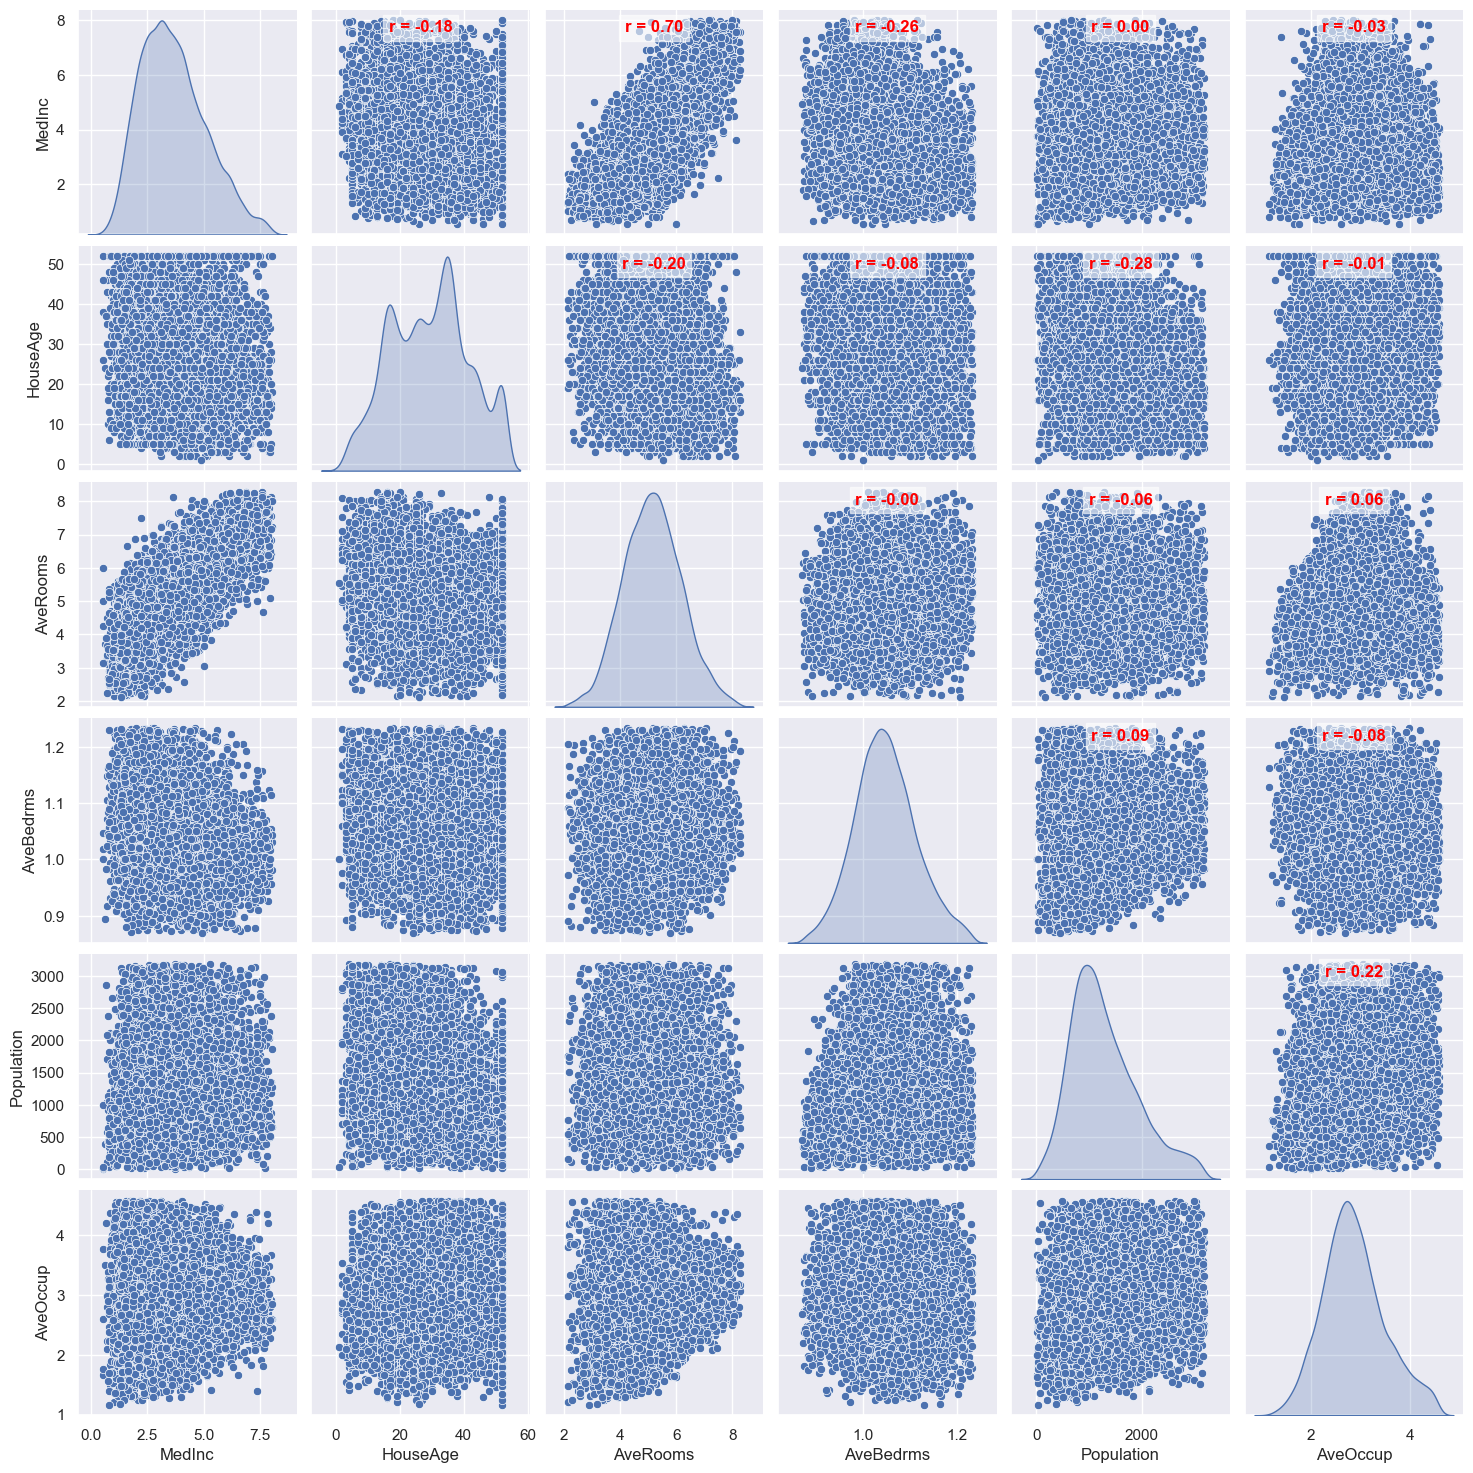

In [14]:
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar coeficiente de correlación con texto en rojo y negrita
def corrfunc(x, y, **kws):
    r, _ = np.corrcoef(x, y)[0, 1], 0
    ax = plt.gca()
    ax.annotate(f'r = {r:.2f}', 
                xy=(.5, .9), 
                xycoords=ax.transAxes, 
                ha='center', 
                fontsize=12, 
                color='red', 
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.6))

# Generar pairplot con coeficiente de correlación
g = sns.pairplot(X_train, diag_kind="kde")
g.map_upper(corrfunc)

plt.show()


Dado que el ingreso medio por vivienda (MedInc) y el promedio de habitaciones por vivienda (AveRooms) están altamente correlacionados (r = 0.7) se puede eliminar una de estás variables. Considerando que la primera tiene una mayor correlación con la variable de interés con respecto a la segunda (0.63 vs 0.27, respectivamente), esta última se eliminará de X.

In [15]:
# Elimincación de el  el promedio de habitaciones por vivienda (AveRooms) de los datos inputs del nuevo modelo
X_train_0 = X_train.drop(columns=['AveRooms'])
X_test_0 = X_test.drop(columns=['AveRooms'])
print(X_train_0.head())
print(X_test_0.head())

       MedInc  HouseAge  AveBedrms  Population  AveOccup
14879  3.4550      37.0   1.061625      1026.0  2.873950
9935   3.6389       4.0   1.060484       455.0  1.834677
11378  4.8750      26.0   1.011494       817.0  3.130268
19171  4.3657      17.0   1.012401      2614.0  2.947012
8032   4.2917      44.0   0.968023       786.0  2.284884
       MedInc  HouseAge  AveBedrms  Population  AveOccup
7794   3.2857      37.0   1.151111       981.0  4.360000
9480   1.5625      21.0   0.923636       715.0  2.600000
9273   7.5000       9.0   0.931579       682.0  3.589474
11949  3.9118      32.0   1.063529      1479.0  3.480000
13831  5.5875       9.0   1.064644      2158.0  2.846966


#### Eliminación de outliers

In [16]:
from statsmodels.tools import add_constant
import statsmodels.api as sm

# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_0 = add_constant(X_train_0)

# Primero se calibra un modelo
modelo_lineal_0 = sm.OLS(y_train, X_train_const_0).fit()

# Calcula la distancia de Cook para cada observación
influence_0 = modelo_lineal_0.get_influence()
cooks_d_0 = influence_0.cooks_distance[0]

# Define el umbral para considerar un outlier (4/n)
threshold_0 = 4 / len(X_train_0)

# Identifica los outliers basados en los índices actuales de X_train
outliers_0 = X_train_0.index[cooks_d_0 > threshold_0]

# Cantidad total de datos antes de eliminar outliers
total_data_before_0 = len(X_train_0)

# Elimina los outliers del conjunto de entrenamiento
X_train_0 = X_train_0.drop(index=outliers_0)
y_train_0 = y_train.drop(index=outliers_0)

# Cantidad total de datos después de eliminar outliers
total_data_after_0 = len(X_train_0)

# Cantidad de outliers eliminados
outliers_eliminated_0 = total_data_before_0 - total_data_after_0

# Porcentaje de outliers eliminados
percentage_eliminated_0= (outliers_eliminated_0 / total_data_before_0) * 100

# Imprimir los resultados
print(f"Cantidad de outliers eliminados: {outliers_eliminated_0}")
print(f"Porcentaje de outliers eliminados: {percentage_eliminated_0:.2f}%")

Cantidad de outliers eliminados: 626
Porcentaje de outliers eliminados: 5.51%


In [17]:
from statsmodels.tools import add_constant
import statsmodels.api as sm

# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_0 = add_constant(X_train_0)

# Ajustar el modelo de regresión utilizando statsmodels
modelo_lineal_0 = sm.OLS(y_train_0, X_train_const_0).fit()

# Para evalaur si disminuyen AIC y BIC es necesario ir eliminando de a una varaible tomando el criterio de p valor 
print("AIC:", int(modelo_lineal_0.aic))
print("BIC:", int(modelo_lineal_0.bic))
print('Orden descendente de la significancia en el modelo')
modelo_lineal_0.pvalues.sort_values()

AIC: 17204
BIC: 17248
Orden descendente de la significancia en el modelo


MedInc        0.000000e+00
HouseAge      0.000000e+00
AveOccup      0.000000e+00
Population    1.325892e-87
AveBedrms     5.459160e-28
const         1.975608e-07
dtype: float64

In [18]:
# Mostrar el resumen del modelo, que incluye los valores p
print(modelo_lineal_0.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     3425.
Date:                Sun, 18 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:21:35   Log-Likelihood:                -8596.2
No. Observations:               10736   AIC:                         1.720e+04
Df Residuals:                   10730   BIC:                         1.725e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5354      0.103     -5.205      0.0

Al igual que en el modelo anterior, modelo_lineal_0, todas las variables independientes fueron significativas (p < 0.0.5) por lo tanto no es necesario eliminar ninguna. Además, los valores de AIC y BIC se pueden seguir explorando en un modelo más simple. Para esto se puede vovler a evaluar en orden descendente la significancia (p valor) de cada variable

In [19]:
from statsmodels.tools import add_constant
import statsmodels.api as sm
X_train_1 = X_train_0.drop(columns=['AveBedrms'])
X_test_1 = X_test_0.drop(columns=['AveBedrms'])


# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_1 = add_constant(X_train_1)

# Primero se calibra un modelo
modelo_lineal_1 = sm.OLS(y_train_0, X_train_const_1).fit()

# Calcula la distancia de Cook para cada observación
influence_1 = modelo_lineal_1.get_influence()
cooks_d_1 = influence_1.cooks_distance[0]

# Define el umbral para considerar un outlier (4/n)
threshold_1 = 4 / len(X_train_1)

# Identifica los outliers basados en los índices actuales de X_train
outliers_1 = X_train_1.index[cooks_d_1 > threshold_1]

# Cantidad total de datos antes de eliminar outliers
total_data_before_1 = len(X_train_1)

# Elimina los outliers del conjunto de entrenamiento
X_train_1 = X_train_1.drop(index=outliers_1)
y_train_1 = y_train_0.drop(index=outliers_1)

# Cantidad total de datos después de eliminar outliers
total_data_after_1 = len(X_train_1)

# Cantidad de outliers eliminados
outliers_eliminated_1 = total_data_before_1 - total_data_after_1

# Porcentaje de outliers eliminados
percentage_eliminated_1= (outliers_eliminated_1 / total_data_before_1) * 100

# Imprimir los resultados
print(f"Cantidad de outliers eliminados: {outliers_eliminated_1}")
print(f"Porcentaje de outliers eliminados: {percentage_eliminated_1:.2f}%")

Cantidad de outliers eliminados: 465
Porcentaje de outliers eliminados: 4.33%


In [20]:
from statsmodels.tools import add_constant
import statsmodels.api as sm

# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_1 = add_constant(X_train_1)

# Ajustar el modelo de regresión utilizando statsmodels
modelo_lineal_1 = sm.OLS(y_train_1, X_train_const_1).fit()

# Para evalaur si disminuyen AIC y BIC es necesario ir eliminando de a una varaible tomando el criterio de p valor 
print("AIC:", int(modelo_lineal_1.aic))
print("BIC:", int(modelo_lineal_1.bic))
print('Orden descendente de la significancia en el modelo')
modelo_lineal_1.pvalues.sort_values()


AIC: 14667
BIC: 14704
Orden descendente de la significancia en el modelo


MedInc         0.000000e+00
HouseAge       0.000000e+00
AveOccup       0.000000e+00
Population    4.332302e-101
const          4.634886e-41
dtype: float64

In [21]:
# Mostrar el resumen del modelo, que incluye los valores p
print(modelo_lineal_1.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     4593.
Date:                Sun, 18 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:21:35   Log-Likelihood:                -7328.9
No. Observations:               10271   AIC:                         1.467e+04
Df Residuals:                   10266   BIC:                         1.470e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4350      0.032     13.479      0.0

Al igual que en el modelo anterior, modelo_lineal, todas las variables independientes fueron significativas (p < 0.0.5) por lo tanto no es necesario eliminar ninguna. Además, los valores de AIC y BIC fueron disminuyeron un 15%, no obstante,se puede seguir explorando un modelo más simple evaluando AIC y BIC. Para esto se puede vovler a evaluar en orden descendente la significancia (p valor) de cada variable.

In [22]:
# En estos casos el promedio de dormitorios por vivienda AveBedrms es la menos significativa, así que se puede elminar
X_train_2 = X_train_1.drop(columns=['Population'])
X_test_2 = X_test_1.drop(columns=['Population'])

# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_2 = add_constant(X_train_2)

# Primero se calibra un modelo
modelo_lineal_2 = sm.OLS(y_train_1, X_train_const_2).fit()

# Calcula la distancia de Cook para cada observación
influence_2 = modelo_lineal_2.get_influence()
cooks_d_2 = influence_2.cooks_distance[0]

# Define el umbral para considerar un outlier (4/n)
threshold_2 = 4 / len(X_train_2)

# Identifica los outliers basados en los índices actuales de X_train
outliers_2 = X_train_2.index[cooks_d_2 > threshold_2]

# Cantidad total de datos antes de eliminar outliers
total_data_before_2 = len(X_train_2)

# Elimina los outliers del conjunto de entrenamiento
X_train_2 = X_train_2.drop(index=outliers_2)
y_train_2 = y_train_1.drop(index=outliers_2)

# Cantidad total de datos después de eliminar outliers
total_data_after_2 = len(X_train_2)

# Cantidad de outliers eliminados
outliers_eliminated_2 = total_data_before_2 - total_data_after_2

# Porcentaje de outliers eliminados
percentage_eliminated_2= (outliers_eliminated_2 / total_data_before_2) * 100

# Imprimir los resultados
print(f"Cantidad de outliers eliminados: {outliers_eliminated_2}")
print(f"Porcentaje de outliers eliminados: {percentage_eliminated_2:.2f}%")

Cantidad de outliers eliminados: 372
Porcentaje de outliers eliminados: 3.62%


In [23]:
from statsmodels.tools import add_constant
import statsmodels.api as sm

# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_2 = add_constant(X_train_2)

# Ajustar el modelo de regresión utilizando statsmodels
modelo_lineal_2 = sm.OLS(y_train_2, X_train_const_2).fit()

# Para evalaur si disminuyen AIC y BIC es necesario ir eliminando de a una varaible tomando el criterio de p valor 
print("AIC:", int(modelo_lineal_2.aic))
print("BIC:", int(modelo_lineal_2.bic))
print('Orden descendente de la significancia en el modelo')
modelo_lineal_2.pvalues.sort_values()


AIC: 13386
BIC: 13414
Orden descendente de la significancia en el modelo


MedInc       0.000000e+00
AveOccup    6.509198e-257
HouseAge    1.102638e-227
const        5.588574e-90
dtype: float64

In [24]:
# Mostrar el resumen del modelo, que incluye los valores p
print(modelo_lineal_2.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     5869.
Date:                Sun, 18 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:21:36   Log-Likelihood:                -6689.1
No. Observations:                9899   AIC:                         1.339e+04
Df Residuals:                    9895   BIC:                         1.341e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6181      0.030     20.322      0.0

Al igual que en el modelo anterior, modelo_lineal_1, todas las variables independientes fueron significativas (p < 0.0.5) por lo tanto no es necesario eliminar ninguna. Además, los valores de AIC y BIC fueron disminuyeron casi un 9%, no obstante, se puede seguir explorando un modelo más simple evaluando AIC y BIC. Para esto se puede vovler a evaluar en orden descendente la significancia (p valor) de cada variable.

In [25]:
# En estos casos el promedio de dormitorios por vivienda AveBedrms es la menos significativa, así que se puede elminar
X_train_3 = X_train_2.drop(columns=['HouseAge'])
X_test_3 = X_test_2.drop(columns=['HouseAge'])

# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_3 = add_constant(X_train_3)

# Primero se calibra un modelo
modelo_lineal_3 = sm.OLS(y_train_2, X_train_const_3).fit()

# Calcula la distancia de Cook para cada observación
influence_3 = modelo_lineal_3.get_influence()
cooks_d_3 = influence_3.cooks_distance[0]

# Define el umbral para considerar un outlier (4/n)
threshold_3 = 4 / len(X_train_3)

# Identifica los outliers basados en los índices actuales de X_train
outliers_3 = X_train_3.index[cooks_d_3 > threshold_3]

# Cantidad total de datos antes de eliminar outliers
total_data_before_3 = len(X_train_3)

# Elimina los outliers del conjunto de entrenamiento
X_train_3 = X_train_3.drop(index=outliers_3)
y_train_3 = y_train_2.drop(index=outliers_3)

# Cantidad total de datos después de eliminar outliers
total_data_after_3 = len(X_train_3)

# Cantidad de outliers eliminados
outliers_eliminated_3 = total_data_before_3 - total_data_after_3

# Porcentaje de outliers eliminados
percentage_eliminated_3= (outliers_eliminated_3 / total_data_before_3) * 100

# Imprimir los resultados
print(f"Cantidad de outliers eliminados: {outliers_eliminated_3}")
print(f"Porcentaje de outliers eliminados: {percentage_eliminated_3:.2f}%")

Cantidad de outliers eliminados: 324
Porcentaje de outliers eliminados: 3.27%


In [26]:
from statsmodels.tools import add_constant
import statsmodels.api as sm

# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_3 = add_constant(X_train_3)

# Ajustar el modelo de regresión utilizando statsmodels
modelo_lineal_3 = sm.OLS(y_train_3, X_train_const_3).fit()

# Para evalaur si disminuyen AIC y BIC es necesario ir eliminando de a una varaible tomando el criterio de p valor 
print("AIC:", int(modelo_lineal_3.aic))
print("BIC:", int(modelo_lineal_3.bic))
print('Orden descendente de la significancia en el modelo')
modelo_lineal_3.pvalues.sort_values()

AIC: 12965
BIC: 12987
Orden descendente de la significancia en el modelo


MedInc       0.000000e+00
const       2.063857e-261
AveOccup    8.555553e-203
dtype: float64

In [27]:
# Mostrar el resumen del modelo, que incluye los valores p
print(modelo_lineal_3.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     7523.
Date:                Sun, 18 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:21:36   Log-Likelihood:                -6479.8
No. Observations:                9575   AIC:                         1.297e+04
Df Residuals:                    9572   BIC:                         1.299e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0023      0.028     35.645      0.0

Al igual que en el modelo anterior, modelo_lineal_2, las dos variables independientes fueron significativas (p < 0.0.5) por lo tanto no es necesario eliminar ninguna. Además, los valores de AIC y BIC fueron disminuyeron un 3% aprox., no obstante, se puede seguir explorando un modelo más simple evaluando AIC y BIC. Para esto se puede vovler a evaluar en orden descendente la significancia (p valor) de cada variable.

In [28]:
# En estos casos el promedio de dormitorios por vivienda AveBedrms es la menos significativa, así que se puede elminar
X_train_4 = X_train_3.drop(columns=['AveOccup'])
X_test_4 = X_test_3.drop(columns=['AveOccup'])

# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_4 = add_constant(X_train_4)

# Primero se calibra un modelo
modelo_lineal_4 = sm.OLS(y_train_3, X_train_const_4).fit()

# Calcula la distancia de Cook para cada observación
influence_4 = modelo_lineal_4.get_influence()
cooks_d_4 = influence_4.cooks_distance[0]

# Define el umbral para considerar un outlier (4/n)
threshold_4 = 4 / len(X_train_4)

# Identifica los outliers basados en los índices actuales de X_train
outliers_4 = X_train_4.index[cooks_d_4 > threshold_4]

# Cantidad total de datos antes de eliminar outliers
total_data_before_4 = len(X_train_4)

# Elimina los outliers del conjunto de entrenamiento
X_train_4 = X_train_4.drop(index=outliers_4)
y_train_4 = y_train_3.drop(index=outliers_4)

# Cantidad total de datos después de eliminar outliers
total_data_after_4 = len(X_train_4)

# Cantidad de outliers eliminados
outliers_eliminated_4 = total_data_before_4 - total_data_after_4

# Porcentaje de outliers eliminados
percentage_eliminated_4= (outliers_eliminated_4 / total_data_before_4) * 100

# Imprimir los resultados
print(f"Cantidad de outliers eliminados: {outliers_eliminated_4}")
print(f"Porcentaje de outliers eliminados: {percentage_eliminated_4:.2f}%")
X_train

Cantidad de outliers eliminados: 289
Porcentaje de outliers eliminados: 3.02%


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup
14879  3.4550      37.0  6.450980   1.061625      1026.0  2.873950
9935   3.6389       4.0  4.237903   1.060484       455.0  1.834677
11378  4.8750      26.0  5.429119   1.011494       817.0  3.130268
19171  4.3657      17.0  6.555806   1.012401      2614.0  2.947012
8032   4.2917      44.0  4.970930   0.968023       786.0  2.284884
...       ...       ...       ...        ...         ...       ...
17206  2.5694      27.0  3.143770   0.955272       777.0  2.482428
6812   3.6083      33.0  5.445000   1.112500      1153.0  2.882500
969    6.0604      20.0  6.219409   0.993671      1181.0  2.491561
20077  2.5729      16.0  5.241259   1.139860       733.0  2.562937
9231   1.9063      18.0  5.661972   1.070423       213.0  3.000000

[11362 rows x 6 columns]

In [29]:
from statsmodels.tools import add_constant
import statsmodels.api as sm

# Agregar una constante a las variables independientes (esto incluye la intersección en el modelo)
X_train_const_4 = add_constant(X_train_4)

# Ajustar el modelo de regresión utilizando statsmodels
modelo_lineal_4 = sm.OLS(y_train_4, X_train_const_4).fit()

# Para evalaur si disminuyen AIC y BIC es necesario ir eliminando de a una varaible tomando el criterio de p valor 
print("AIC:", int(modelo_lineal_4.aic))
print("BIC:", int(modelo_lineal_4.bic))
print('Orden descendente de la significancia en el modelo')
modelo_lineal_4.pvalues.sort_values()
X_train

AIC: 12605
BIC: 12619
Orden descendente de la significancia en el modelo


MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup
14879  3.4550      37.0  6.450980   1.061625      1026.0  2.873950
9935   3.6389       4.0  4.237903   1.060484       455.0  1.834677
11378  4.8750      26.0  5.429119   1.011494       817.0  3.130268
19171  4.3657      17.0  6.555806   1.012401      2614.0  2.947012
8032   4.2917      44.0  4.970930   0.968023       786.0  2.284884
...       ...       ...       ...        ...         ...       ...
17206  2.5694      27.0  3.143770   0.955272       777.0  2.482428
6812   3.6083      33.0  5.445000   1.112500      1153.0  2.882500
969    6.0604      20.0  6.219409   0.993671      1181.0  2.491561
20077  2.5729      16.0  5.241259   1.139860       733.0  2.562937
9231   1.9063      18.0  5.661972   1.070423       213.0  3.000000

[11362 rows x 6 columns]

In [30]:
# Mostrar el resumen del modelo, que incluye los valores p
print(modelo_lineal_4.summary())

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                 1.251e+04
Date:                Sun, 18 Aug 2024   Prob (F-statistic):               0.00
Time:                        23:21:36   Log-Likelihood:                -6300.6
No. Observations:                9286   AIC:                         1.261e+04
Df Residuals:                    9284   BIC:                         1.262e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2456      0.014     17.472      0.0

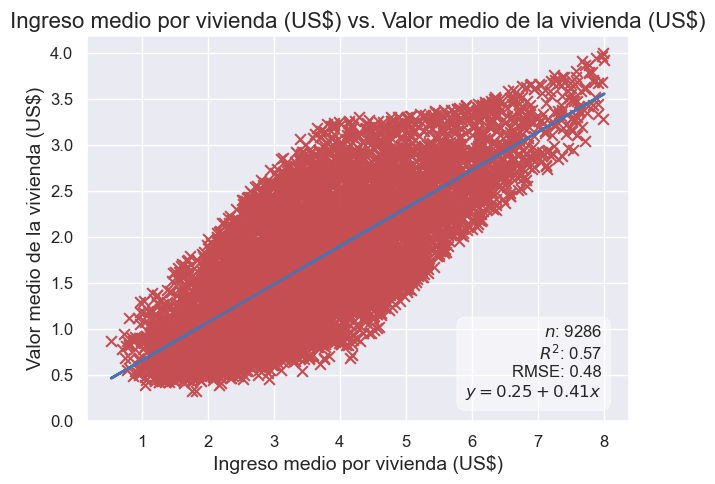

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

# Realizar predicciones
y_pred = modelo_lineal_4.predict(X_train_const_4 )

# Calcular el RMSE
rmse = np.sqrt(mean_squared_error(y_train_4, y_pred))

# Tamaño de la muestra
n = len(X_train_4)

# Extraer los coeficientes del modelo
b0 = modelo_lineal_4.params[0]
b1 = modelo_lineal_4.params[1]

plt.figure(figsize=(7, 5))
plt.title('Ingreso medio por vivienda (US\$) vs. Valor medio de la vivienda (US\$)', fontsize=16)
plt.ylabel('Valor medio de la vivienda (US\$)', fontsize=14)
plt.xlabel('Ingreso medio por vivienda (US\$)', fontsize=14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

# Si 'MedInc' es la columna que estás utilizando para la predicción:
plt.scatter(X_train_4['MedInc'], y_train_4, color='r', marker="x", s=60)
plt.plot(X_train_4['MedInc'], y_pred, color="b", linewidth=2)

# Agregar R-squared, n, RMSE y la ecuación del modelo en el gráfico
plt.text(0.95, 0.05, f'$n$: {n}\n$R^2$: {modelo_lineal_4.rsquared:.2f}\nRMSE: {rmse:.2f}\n$y = {b0:.2f} + {b1:.2f}x$', 
         fontsize=12, ha='right', va='bottom', transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.ylim(0)  # Establece el límite inferior del eje y en cero
plt.show()


Al igual que en el modelo anterior, modelo_lineal_3, las dos variables independientes fueron significativas (p < 0.0.5) por lo tanto no es necesario eliminar ninguna. Además, los valores de AIC y BIC fueron disminuyeron casi un 3% aprox., Por lo tanto, se podría inferir que no hay diferencia entre el modelo model_lineal_3 y model_lineal_4 ya que ambas metricas y estadística evaluadas.

### Diagnóstico del Modelo Lineal

En un modelo de regresión lineal múltiple, las suposiciones principales incluyen la normalidad de los errores ($𝑒_{𝑖}$), la homocedasticidad (igualdad de varianza de los $𝑒_{𝑖}$), independencia de los errores, y una relación lineal entre las variables independientes y la variable dependiente. No es necesario que la depdendiente ($y$) y las independientes sean normales ($X$), pero los residuos o $𝑒_{𝑖}$ del modelo deben seguir una distribución normal para que los intervalos de confianza y las pruebas de hipótesis sean válidos.

**Normalidad**\
Para evluar la normalidad en la distribución de los residuos, la prueba de Kolmogorov-Smirnov (K-S) es una de las más adecuada para muestras grandes de datos (n > 50) y se puede utilizar para comparar los residuos con una distribución normal.

In [32]:
from scipy.stats import kstest, norm

# Prueba de Kolmogorov-Smirnov
ks_test_0 = kstest(modelo_lineal_0.resid, 'norm', args=(modelo_lineal_0.resid.mean(), modelo_lineal_0.resid.std()))
ks_test_1 = kstest(modelo_lineal_1.resid, 'norm', args=(modelo_lineal_1.resid.mean(), modelo_lineal_1.resid.std()))
ks_test_2 = kstest(modelo_lineal_2.resid, 'norm', args=(modelo_lineal_2.resid.mean(), modelo_lineal_2.resid.std()))
ks_test_3 = kstest(modelo_lineal_3.resid, 'norm', args=(modelo_lineal_3.resid.mean(), modelo_lineal_3.resid.std()))
ks_test_4 = kstest(modelo_lineal_4.resid, 'norm', args=(modelo_lineal_4.resid.mean(), modelo_lineal_4.resid.std()))

print('El valor p de la prueba de Kolmogorov-Smirnov para:'
      '\n modelo_0 =', ks_test_0.pvalue,
      '\n modelo_1 =', ks_test_1.pvalue,
      '\n modelo_2 =', ks_test_2.pvalue,
      '\n modelo_3 =', ks_test_3.pvalue,
      '\n modelo_4 =', ks_test_4.pvalue
     )

El valor p de la prueba de Kolmogorov-Smirnov para:
 modelo_0 = 2.4918973100616914e-09 
 modelo_1 = 3.0384989895504034e-08 
 modelo_2 = 1.1580543913035553e-07 
 modelo_3 = 7.278803828186907e-08 
 modelo_4 = 1.4103819310367567e-13


Los resultados de la prueba de Kolmogorov-Smirnov revelaron valores p significativos en todos los modelos analizados, lo que conduce al rechazo de la hipótesis nula de normalidad de los residuos. Esta evidencia empírica contradice el supuesto fundamental de normalidad distribucional subyacente a muchos procedimientos inferenciales en el contexto de regresión lineal. La no conformidad con esta premisa puede comprometer la validez y confiabilidad de los intervalos de confianza y pruebas de hipótesis construidos bajo el supuesto de normalidad, potencialmente llevando a conclusiones erróneas. Por lo tanto, es fundamental que los resultados derivados de los modelos sean interpretados con precaución, y se considere la posibilidad de aplicar transformaciones a las variables o utilizar métodos robustos alternativos para manejar la falta de normalidad.

**Homocedasticidad**\
La homocedasticidad se refiere a que la varianza de los errores es constante a lo largo de todos los niveles de las variables independientes. Para probar la homocedasticidad, se puede utilizar la prueba de Breusch-Pagan o la prueba de White. Un p-valor bajo (generalmente menor a 0.05) indicaría heterocedasticidad, es decir, que las varianzas no son constantes.

In [33]:
import statsmodels.stats.api as sms
test_0 = sms.het_breuschpagan(modelo_lineal_0.resid, modelo_lineal_0.model.exog, robust=True)
test_1 = sms.het_breuschpagan(modelo_lineal_1.resid, modelo_lineal_1.model.exog, robust=True)
test_2 = sms.het_breuschpagan(modelo_lineal_2.resid, modelo_lineal_2.model.exog, robust=True)
test_3 = sms.het_breuschpagan(modelo_lineal_3.resid, modelo_lineal_3.model.exog, robust=True)
test_4 = sms.het_breuschpagan(modelo_lineal_4.resid, modelo_lineal_4.model.exog, robust=True)

print('El valor p de la prueba de Breusch-Pagan para:'
      '\n modelo_0 =', test_0[1],
      '\n modelo_1 =', test_1[1],
      '\n modelo_2 =', test_2[1],
      '\n modelo_3 =', test_3[1],
      '\n modelo_4 =', test_4[1])

El valor p de la prueba de Breusch-Pagan para:
 modelo_0 = 5.89761674376215e-103 
 modelo_1 = 5.620318070312362e-76 
 modelo_2 = 3.1616735166818865e-52 
 modelo_3 = 2.6502972881189265e-38 
 modelo_4 = 0.000366108361108331


En todos los modelos analizados, la prueba de Breusch-Pagan resultó significativa (valor p < 0.05). Esto implica el rechazo de la hipótesis nula que asume una distribución normal de los residuos, aceptándose así la hipótesis alternativa de heterocedasticidad. En consecuencia, se evidencia que los residuos de cada modelo presentan una distribución heteroscedástica caracterizada por una varianza de los errores que no es constante a lo largo de los valores predichos, esto compromete la eficiencia y consistencia de los estimadores obtenidos mediante mínimos cuadrados ordinarios y en consecuencia, generar conclusiones erróneas.

**Independencia**\
Para la autocorrelación en los residuos se aplica la prueba de Durbin-Watson Valores cercanos a 2 indican poca autocorrelación. Valores cercanos a 0 sugieren autocorrelación positiva, mientras que valores cercanos a 4 sugieren autocorrelación negativa.

In [34]:
from statsmodels.stats.stattools import durbin_watson

dw_test_0 = durbin_watson(modelo_lineal_0.resid)
dw_test_1 = durbin_watson(modelo_lineal_1.resid)
dw_test_2 = durbin_watson(modelo_lineal_2.resid)
dw_test_3 = durbin_watson(modelo_lineal_3.resid)
dw_test_4 = durbin_watson(modelo_lineal_4.resid)
print('El valor p de la prueba de Durbin-Watson para:' 
      '\n modelo_0 =', dw_test_0,
      '\n modelo_1 =', dw_test_1, 
      '\n modelo_2 =', dw_test_2,
      '\n modelo_3 =', dw_test_3,
      '\n modelo_4 =', dw_test_4)


El valor p de la prueba de Durbin-Watson para:
 modelo_0 = 1.9787634387223159 
 modelo_1 = 1.9962799233517126 
 modelo_2 = 2.005038648685486 
 modelo_3 = 1.985320896989367 
 modelo_4 = 1.9845691188924022


El estadístico Durbin-Watson presentó valores próximos a 2 en la mayoría de los modelos evaluados, indicando una ausencia aparente de autocorrelación de primer orden en los residuos. Este resultado es indicativo de que la hipótesis de independencia de los términos de error, fundamental para la eficiencia y consistencia de los estimadores de mínimos cuadrados ordinarios, no parece ser violada de manera significativa en estos modelos, haciendo que las estimaciones del modelo sean más confiables.

**Linealidad**\
La prueba RESET de Ramsey evalúa si el modelo lineal está correctamente especificado o si se necesitan términos adicionales para capturar la relación entre las variables.

In [35]:
import numpy as np
from statsmodels.stats.diagnostic import linear_reset

# Realizar la prueba RESET de Ramsey para cada modelo
reset_test_0 = linear_reset(modelo_lineal_0, power=3, test_type='fitted', use_f=False, cov_type='nonrobust', cov_kwargs=None)
reset_test_1 = linear_reset(modelo_lineal_1, power=3, test_type='fitted', use_f=False, cov_type='nonrobust', cov_kwargs=None)
reset_test_2 = linear_reset(modelo_lineal_2, power=3, test_type='fitted', use_f=False, cov_type='nonrobust', cov_kwargs=None)
reset_test_3 = linear_reset(modelo_lineal_3, power=3, test_type='fitted', use_f=False, cov_type='nonrobust', cov_kwargs=None)
reset_test_4 = linear_reset(modelo_lineal_4, power=3, test_type='fitted', use_f=False, cov_type='nonrobust', cov_kwargs=None)

# Mostrar los resultados
print('El valor p de la prueba de RESET para:'
      '\n modelo_0 =', reset_test_0.pvalue, 
      '\n modelo_1 =', reset_test_1.pvalue, 
      '\n modelo_2 =', reset_test_2.pvalue,
      '\n modelo_3 =', reset_test_3.pvalue,
      '\n modelo_4 =', reset_test_4.pvalue)


El valor p de la prueba de RESET para:
 modelo_0 = 1.4999306804200247e-98 
 modelo_1 = 5.031420399500232e-73 
 modelo_2 = 9.959065219861912e-47 
 modelo_3 = 9.872893399331669e-24 
 modelo_4 = 0.007720305458207147


C:\Users\adria\anaconda3\envs\Machine_Learning\Lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


Los resultados de la prueba RESET fueron significativas (p < 0.05) en todos los modelos. Este resutlado sugiere una posible especificación incorrecta del modelo lineal. En consecuencia, es probable que el modelo omita términos no lineales o interacciones relevantes entre las variables independientes. Por lo tanto, es esencial reconsiderar y ajustar la estructura del modelo para incluir los términos no lineales o interacciones necesarios, con el fin de mejorar la precisión y validez de las predicciones realizadas.

In [36]:
import numpy as np
import pandas as pd

# Supongamos que tienes y_train y que los modelos ya han sido entrenados como modelo_lineal_0, modelo_lineal_1, etc.
modelos = [modelo_lineal_0, modelo_lineal_1, modelo_lineal_2, modelo_lineal_3, modelo_lineal_4]
nombres_modelos = ['Modelo 0', 'Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4']

# Lista de los conjuntos de entrenamiento
X_trains = [X_train_0, X_train_1, X_train_2, X_train_3, X_train_4]

# Obtener el n total para X_train_0
n_total = len(X_train_0)

# Obtener el AIC del modelo_lineal_0 para calcular AIC relativo
aic_base = int(modelo_lineal_0.aic)
bic_base = int(modelo_lineal_0.bic)

resultados = []

for nombre, modelo, X_train_i in zip(nombres_modelos, modelos, X_trains):
    y_train_i = modelo.model.endog  # valores observados en el entrenamiento
    y_pred_i = modelo.fittedvalues  # predicciones del modelo en el conjunto de entrenamiento
    
    # Varianza total de la variable objetivo
    varianza_total = np.var(y_train_i, ddof=1)
    
    # Varianza explicada por el modelo
    varianza_explicada = np.var(y_pred_i, ddof=1)
    
    # Varianza no explicada (residual)
    varianza_no_explicada = varianza_total - varianza_explicada
    
    # Proporción de varianza explicada
    proporcion_varianza_explicada = varianza_explicada / varianza_total
    
    # Número de observaciones
    n = len(y_train_i)
    
    # AIC y BIC
    aic = int(modelo.aic)
    bic = int(modelo.bic)
    
    # Cálculo de n relativo, AIC relativo y BIC relativo (como porcentaje y redondeados a enteros)
    n_relativo = int((n / n_total) * 100)
    aic_relativo = int((aic / aic_base) * 100)
    bic_relativo = int((bic / bic_base) * 100)
    
    # Nombres de las columnas del conjunto de entrenamiento
    columnas_X = ', '.join(X_train_i.columns)
    
    # Redondeamos los resultados y los agregamos a la lista de resultados
    resultados.append([nombre, n, n_relativo, aic, aic_relativo, bic, bic_relativo, 
                       round(varianza_total, 3), 
                       round(varianza_explicada, 3), 
                       round(varianza_no_explicada, 3), 
                       round(proporcion_varianza_explicada, 3),
                       columnas_X])

# Convertimos los resultados en un DataFrame
df_resultados_varianza = pd.DataFrame(resultados, columns=['Modelo', 'n', 'n rel (%)', 
                                                           'AIC', r'AIC rel (%)', 
                                                           'BIC', r'BIC rel (%)', 
                                                           'var total', 'var explicada', 
                                                           'var no explicada', 
                                                           'var explicada / var total', 
                                                           'Variables independientes'])

# Aplicar estilo para centrar los valores, redondear a 3 decimales y alinear los títulos a la derecha
df_resultados_varianza_styled = df_resultados_varianza.style.set_properties(**{
    'text-align': 'center'}).set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'center')]}]  # Alinea los títulos a la derecha
).format(precision=3)

# Mostrar los resultados con estilo aplicado
df_resultados_varianza_styled



**¿El modelo está capturando el comportamiento del target? Expanda su respuesta**

La varianza ($\sigma^2$) es una medida crítica para entender la eficacia de un modelo estadístico en la captura de la variabilidad de una variable objetivo. La varianza total ($\sigma^2_{\text{total}}$) representa la variabilidad inherente en los datos observados, mientras que la varianza explicada por el modelo ($\sigma^2_{\text{explicada}}$) indica cuánto de esta variabilidad puede ser atribuida a las variables predictoras incluidas en el modelo.

### Análisis de los Resultados

#### Varianza Total y Explicada
Observando la tabla anterior, se puede ver que la varianza total ($\sigma^2_{\text{total}}$) disminuye de 0.754 en el Modelo 0, con cuatro variables independientes, a 0.534 en el Modelo 4 constituido por una variable independiente. Esta reducción gradual a la simplicidad de los modelos varía en su constitución. La varianza explicada como en la no explicada en los Modelos 1 y 2 disminuyen, pero la segunda a una tasa mayor. En los Modelos 3 y 4, la reducción de la varianza total se atribuye únicamente a una disminución en la varianza explicadacada ya que la varianza no explicada se mantiene constante. Como resultado, la proporción de la varianza explicada sobre la varianza total, conocida como coeficiente de determinación (R²), alcanza su valor máximo (0.64) en los Modelos 1 y 2. Esto sugiere que la variabilidad del valor medio de la vivienda (MedHouseVal) puede ser modelada linealmente en función del ingreso medio por vivienda (MedInc), la edad promedio de la vivienda (HouseAge), y el promedio de ocupantes por vivienda (AveOccup). Por lo tanto, los modelos están capturando el comportamiento de la variable dependiente (MedHouseVal), pero solo logran explicar entre el 57% y el 64% de su variabilidad. Esto indica que, aunque el modelo proporciona una representación razonable, hay una porción significativa de la variabilidad que aún no es explicada, lo que podría requerir la inclusión de variables adicionales o la consideración de modelos más complejos.\


#### Eliminación de outliers (valores atípicos) mediante la Distancia de Cook
El tamaño de la muestra ($n$) se reduce ligeramente de 10,736 en el Modelo 0 a 9,286 en el Modelo 4. Esta reducción en $n$ se debe a la eliminación de observaciones influyentes, comúnmente conocidas como outliers (valores atípicos), mediante el uso de la distancia de Cook. Este método estadístico se emplea para identificar y excluir puntos de datos que tienen un impacto desproporcionado en los coeficientes del modelo, lo que podría distorsionar los resultados y llevar a inferencias erróneas.\
La eliminación de estos outliers es crucial, ya que permite mejorar la estabilidad y la fiabilidad de los parámetros estimados, asegurando que las estimaciones sean representativas del comportamiento general de la variable objetivo (target). Aunque esto conlleva una reducción en $n$, este proceso es beneficioso desde un punto de vista estadístico porque reduce el sesgo en los coeficientes y evita la influencia indebida de valores extremos que pueden llevar a conclusiones incorrectas.\
El $n_{\text{relativo}}$ muestra que el Modelo 4 utiliza el 81% de las observaciones originales, lo que refleja un equilibrio adecuado entre la exclusión de outliers y el mantenimiento de un tamaño de muestra suficientemente grande para realizar estimaciones robustas. Este enfoque asegura que, aunque se eliminen algunas observaciones, el modelo sigue siendo capaz de capturar la estructura subyacente de los datos sin estar comprometido por valores atípicos que podrían afectar negativamente la generalización del modelo a nuevos datos.


#### Disminución de AIC y BIC
Es importante destacar que un R² alto no siempre implica un mejor modelo. Un modelo con un R² elevado pero con una alta complejidad podría ser susceptible al sobreajuste. Por tanto, es fundamental considerar otros criterios de evaluación, como la parsimonia del modelo, la significancia estadística de los coeficientes y la capacidad del modelo para realizar predicciones precisas en nuevos datos. En este sentido, se evaluó la disminución de variables indpendientes descartando en cada modelo la de menor significancia y evaluando una mejora en las metricas del criterio de Información de Akaike (AIC) y criterio de Información Bayesiano (BIC) que buscan un equilibrio la bondad de ajuste del modelo (qué tan bien explica los datos) y su complejidad (número de parámetros).\
En la tabla evidencia una disminución progresiva en los valores de AIC y BIC desde el Modelo 0 hasta el Modelo 4. El AIC del Modelo 0 comienza en 17,204 y desciende a 12,605 en el Modelo 4, mientras que el BIC disminuye de 17,248 a 12,619 en el mismo rango. Sin embargo, las reducciones más notables en AIC y BIC se observan en los Modelos 1 y 2, donde el AIC disminuye en un 15% y un 23% respectivamente, y el BIC sigue una tendencia similar. Estas reducciones son estadísticamente significativas, lo que sugiere una mejora en la eficiencia del modelo.\
La reducción en AIC y BIC puede ser atribuida, en gran medida, a la eliminación de variables que no contribuyen significativamente a la explicación de la variabilidad de la variable objetivo. Al descartar estas variables, se logra una mayor parsimonia en el modelo, es decir, un modelo más simple que ofrece un ajuste comparable o mejor al de los modelos más complejos. Esto refuerza el principio estadístico de que un modelo más simple, siempre que mantenga su capacidad explicativa, es preferible debido a su mayor generalización a nuevos datos y su menor propensión al sobreajuste.

#### Interpretación del Diagnóstico
Los análisis de diagnóstico revelaron problemas significativos en los supuestos fundamentales de los modelos de regresión, incluyendo la violación de la normalidad y homocedasticidad de los residuos y una posible especificación incorrecta del modelo. Estos problemas aumentan la probabilidad de que los estimadores de los parámetros estén sesgados, lo que compromete la validez y confiabilidad de las inferencias y predicciones realizadas. Además, A pesar de que no se encontró evidencia de autocorrelación, la prueba RESET indicó una posible especificación incorrecta del modelo, sugiriendo la necesidad de incluir términos no lineales o interacciones entre las variables. Por lo tanto, es fundamental la cautela en la interpretación de los resultados y considerar la aplicación de transformaciones de variables o modelos alternativos más robustos para abordar estas limitaciones, así como también, la realización de una validación cruzada para garantizar la robustez de los resultados.

### Conclusión

En resumen, los modelos presentados pueden explicar la variabilidad del target con una bondad adecuada de ajuste adecuada, así como también muestran una evolución hacia una mayor simplicidad sin sacrificar excesivamente la capacidad explicativa, como lo evidencian las reducciones en AIC y BIC, y los aumentos de R² alcanzados en los modelos 1 y 2. Sin embargo, las violaciones de los supuestos clave y la moderada capacidad de explicación de la varianza sugieren que, aunque se ha avanzado, hay oportunidades para optimizar aún más los modelos mediante ajustes adicionales y la consideración de técnicas de modelado más avanzadas.


# Punto 4

In [37]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Asegurarse de que X_test tiene la constante agregada
X_test_0 = sm.add_constant(X_test_0)
X_test_1 = sm.add_constant(X_test_1)
X_test_2 = sm.add_constant(X_test_2)
X_test_3 = sm.add_constant(X_test_3)
X_test_4 = sm.add_constant(X_test_4)

# Realizar predicciones para cada modelo
y_pred_0 = modelo_lineal_0.predict(X_test_0)
y_pred_1 = modelo_lineal_1.predict(X_test_1)
y_pred_2 = modelo_lineal_2.predict(X_test_2)
y_pred_3 = modelo_lineal_3.predict(X_test_3)
y_pred_4 = modelo_lineal_4.predict(X_test_4)

# Lista de modelos y predicciones
modelos = [modelo_lineal_0, modelo_lineal_1, modelo_lineal_2, modelo_lineal_3, modelo_lineal_4]
nombres_modelos = ['Modelo 0', 'Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4']

# Asumiendo que ya tienes y_test y las predicciones y_pred_* correspondientes para cada modelo

# Crear un DataFrame para almacenar los resultados
resultados = []

# Calcular las métricas del modelo y de validación
for nombre, modelo, y_pred in zip(nombres_modelos, modelos, [y_pred_0, y_pred_1, y_pred_2, y_pred_3, y_pred_4]):
    # Métricas del modelo
    r2_modelo = modelo.rsquared.round(3)
    aic = int(modelo.aic)
    bic = int(modelo.bic)
    
    # Métricas del conjunto de validación
    r2_validacion = r2_score(y_test, y_pred).round(3)
    mse = mean_squared_error(y_test, y_pred).round(2)
    mae = mean_absolute_error(y_test, y_pred).round(2)
    
    # Agregar a los resultados
    resultados.append([nombre, r2_modelo, aic, bic, mse, mae, r2_validacion])

# Convertir los resultados en un DataFrame
df_resultados = pd.DataFrame(resultados, columns=['Modelo', 'R² (Train)', 'AIC (Train)', 'BIC (Train)', 'MSE (Test)', 'MAE (Test)', 'R² (Test)'])

# Mostrar la tabla en consola
df_resultados


Modelo  R² (Train)  AIC (Train)  BIC (Train)  MSE (Test)  MAE (Test)  \
0  Modelo 0       0.615        17204        17248        0.43        0.50   
1  Modelo 1       0.642        14667        14704        0.44        0.50   
2  Modelo 2       0.640        13386        13414        0.46        0.51   
3  Modelo 3       0.611        12965        12987        0.50        0.53   
4  Modelo 4       0.574        12605        12619        0.55        0.55   

   R² (Test)  
0      0.495  
1      0.487  
2      0.468  
3      0.416  
4      0.352

# Punto 5

## Regresión Ridge

Para ver el efecto de las penalizaciones L1 y L2 en la regresión lineal, vamos a ver el dataset de las 50 startups. Ya vimos, cuando hicimos Selección de modelo mediante eliminación hacia atrás, encontramos que con solo dos atributos ("R&D Spend", "Marketing Spend"), obtuvimos un mejor modelo. Veamos cómo nos afecta el hecho de usar estas penalidades.

In [38]:
X_train.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup
14879  3.4550      37.0  6.450980   1.061625      1026.0  2.873950
9935   3.6389       4.0  4.237903   1.060484       455.0  1.834677
11378  4.8750      26.0  5.429119   1.011494       817.0  3.130268
19171  4.3657      17.0  6.555806   1.012401      2614.0  2.947012
8032   4.2917      44.0  4.970930   0.968023       786.0  2.284884

In [39]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

X_train_scaled = sc_X.fit_transform(X_train)

print(f"Las medias del escalador es {sc_X.mean_}")

Las medias del escalador es [3.65410042e+00 2.93091885e+01 5.15083971e+00 1.04732514e+00
 1.28510975e+03 2.86489159e+00]


In [40]:
print(f"Los desvío estándar del escalador es {np.sqrt(sc_X.var_)}")

Los desvío estándar del escalador es [1.43654688e+00 1.21637410e+01 1.03307146e+00 6.54498879e-02
 6.36133172e+02 6.23288147e-01]


In [41]:

# Escalemos el set de testeo
X_test_scaled = sc_X.transform(X_test)
X_train_scaled

array([[-0.13859654,  0.63227353,  1.25851961,  0.21848026, -0.40731998,
         0.01453259],
       [-0.01058122, -2.08070762, -0.88371087,  0.20105046, -1.30493077,
        -1.65286982],
       [ 0.84988495, -0.27205352,  0.26937059, -0.54745531, -0.73586754,
         0.42576874],
       ...,
       [ 1.67505816, -0.76532282,  1.03436173, -0.81977612, -0.16366031,
        -0.5989692 ],
       [-0.75263845, -1.09416902,  0.08752447,  1.41382975, -0.86791536,
        -0.48445414],
       [-1.21666786, -0.92974592,  0.49476938,  0.35290196, -1.68535426,
         0.21676718]])

In [42]:
y_train

14879    1.569
9935     1.302
11378    2.304
19171    2.159
8032     3.147
         ...  
17206    2.750
6812     2.120
969      2.479
20077    1.188
9231     0.958
Name: MedHouseVal, Length: 11362, dtype: float64

El mejor valor de alpha es: 3.55
MSE en el conjunto de prueba: 0.39
MAE en el conjunto de prueba: 0.47


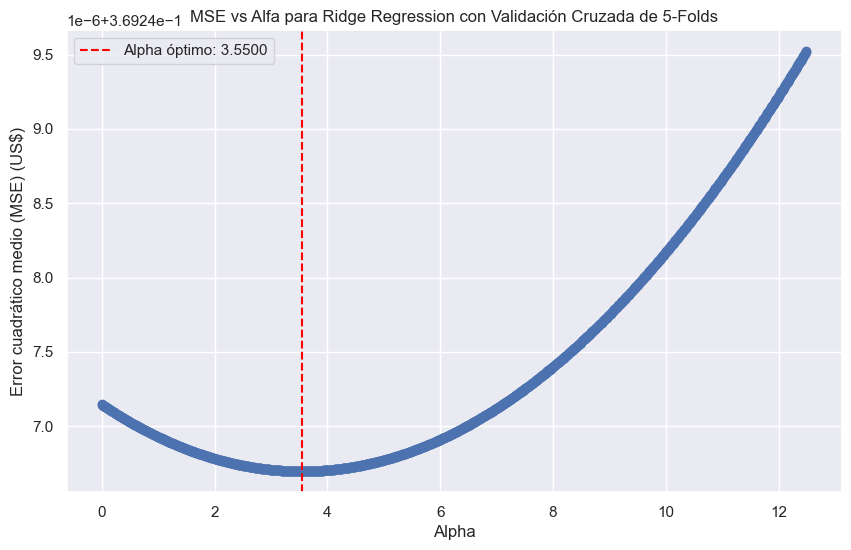

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
import numpy as np
import matplotlib.pyplot as plt

# Define el rango de alpha para explorar
alpha_range = np.arange(0, 12.5, 0.01)

# Creamos el modelo Ridge
ridge_model = Ridge()

# Creamos el GridSearchCV con la métrica MSE
grid_search = GridSearchCV(estimator=ridge_model, 
                           param_grid={'alpha': alpha_range}, 
                           scoring=make_scorer(mean_squared_error, greater_is_better=False),
                           cv=5)

# Entrenamos el GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Obtenemos el mejor modelo
best_model = grid_search.best_estimator_

# Predecimos sobre los datos de prueba
y_pred_ridge = best_model.predict(X_test_scaled)

# Calculamos el MSE y MAE en los datos de prueba
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)

print(f"El mejor valor de alpha es: {grid_search.best_params_['alpha'].round(2)}")
print(f"MSE en el conjunto de prueba: {ridge_mse.round(2)}")
print(f"MAE en el conjunto de prueba: {ridge_mae.round(2)}")

# Graficar MSE versus alpha
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, -grid_search.cv_results_['mean_test_score'], marker='o')
plt.axvline(x=grid_search.best_params_['alpha'], color='red', linestyle='--', label=f'Alpha óptimo: {grid_search.best_params_["alpha"]:.4f}')
plt.xlabel('Alpha')
plt.ylabel('Error cuadrático medio (MSE) (US\$)')
plt.title('MSE vs Alfa para Ridge Regression con Validación Cruzada de 5-Folds')
plt.legend()
plt.grid(True)
plt.show()


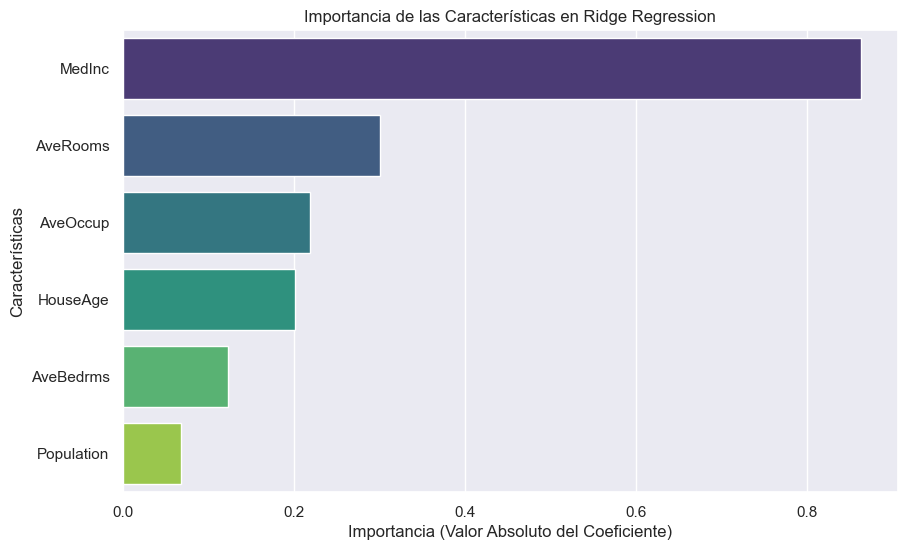

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Asumiendo que 'best_model' es tu modelo Ridge entrenado con el mejor alpha
coef = best_model.coef_

# Obtener el orden de importancia basado en el valor absoluto de los coeficientes
importance = np.abs(coef)
sorted_idx = np.argsort(importance)[::-1]  # Orden descendente

# Ordenar las características
features = X_train.columns[sorted_idx]
sorted_importance = importance[sorted_idx]

# Graficar la importancia de características
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=features, palette="viridis")
plt.title('Importancia de las Características en Ridge Regression')
plt.xlabel('Importancia (Valor Absoluto del Coeficiente)')
plt.ylabel('Características')
plt.show()


Al igual que para los modelos lineales, la variable más importante es el ingreso promedio por hogar (MedInc)

# Punto 6

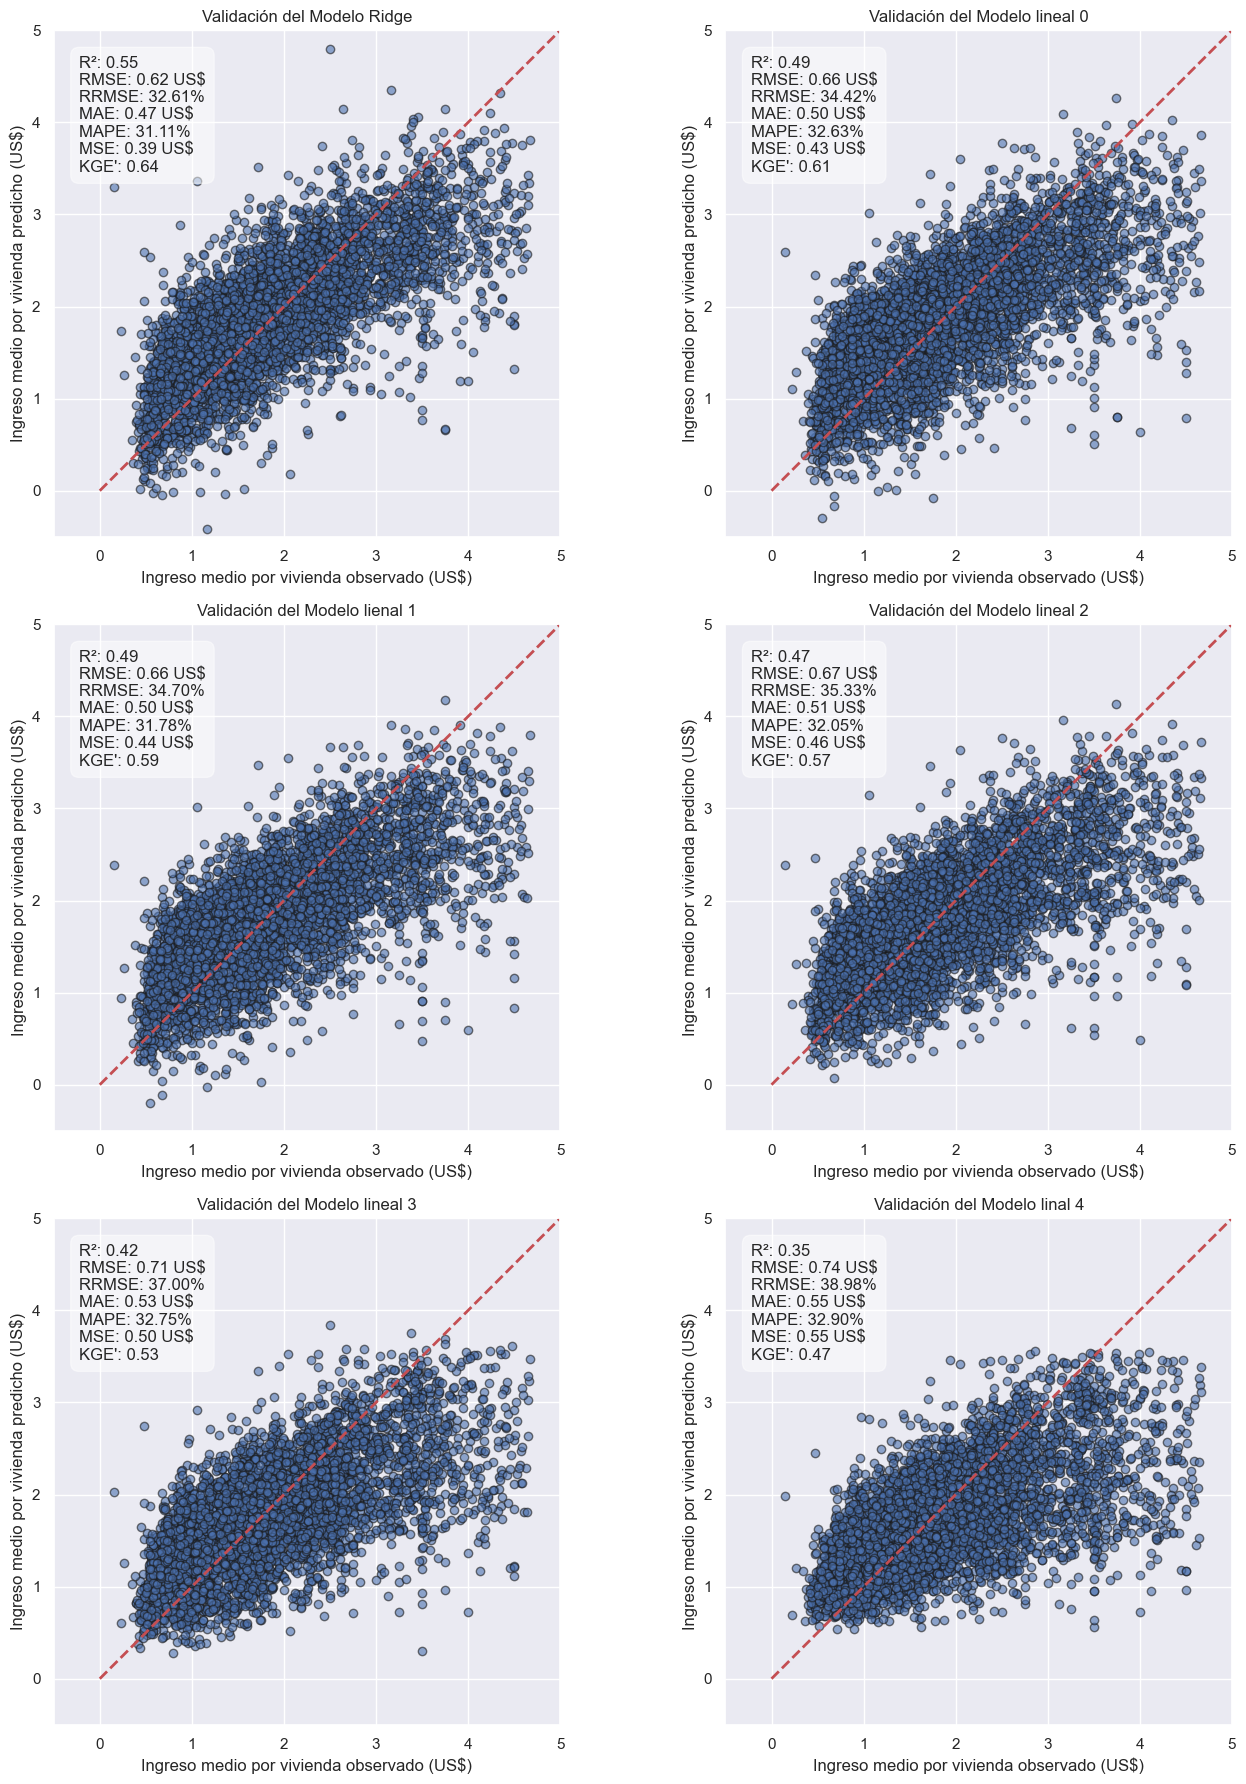

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Función para calcular el RRMSE y MAPE
def rrmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Función para calcular el KGE (Kling-Gupta Efficiency)
def kge(observed, simulated):
    correlation = np.corrcoef(observed, simulated)[0, 1]
    std_dev_ratio = np.std(simulated) / np.std(observed)
    mean_ratio = np.mean(simulated) / np.mean(observed)
    
    kge = 1 - np.sqrt(
        (correlation - 1) ** 2 + 
        (std_dev_ratio - 1) ** 2 + 
        (mean_ratio - 1) ** 2
    )
    
    return kge

# Lista de predicciones y modelos, colocando primero el modelo de Ridge
predicciones = [y_pred_ridge, y_pred_0, y_pred_1, y_pred_2, y_pred_3, y_pred_4]
titulos = ['Modelo Ridge', 'Modelo lineal 0', 'Modelo lienal 1', 'Modelo lineal 2', 'Modelo lineal 3', 'Modelo linal 4']

plt.figure(figsize=(14, 18))

# Crear gráficos para cada modelo
for i, (y_pred, titulo) in enumerate(zip(predicciones, titulos), start=1):
    # Calcular métricas
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rrmse_value = rrmse(y_test, y_pred) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mape_value = mape(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    kge_value = kge(y_test, y_pred)
    
    # Crear subgráfico
    plt.subplot(3, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
    plt.plot([0, 5], [0, 5], 'r--', lw=2)  # Línea de referencia
    plt.title(f'Validación del {titulo}')
    plt.xlabel('Ingreso medio por vivienda observado (US$)')
    plt.ylabel('Ingreso medio por vivienda predicho (US$)')
    plt.grid(True)
    
    # Configurar límites y relación de aspecto
    plt.xlim(-0.5, 5)
    plt.ylim(-0.5, 5)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Agregar métricas al gráfico
    plt.text(0.05, 0.95, 
             f'R²: {r2:.2f}' +
             f'\nRMSE: {rmse:.2f} US$' +
             f'\nRRMSE: {rrmse_value:.2f}%' +
             f'\nMAE: {mae:.2f} US$' +
             f'\nMAPE: {mape_value:.2f}%' +
             f'\nMSE: {mse:.2f} US$' +
             f'\nKGE\': {kge_value:.2f}', 
             fontsize=12, ha='left', va='top', transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


### ¿Cuál da mejores resultados (usando MSE y MAE)? Conjeturar por qué el mejor modelo mejora. ¿Qué error puede haberse reducido?
**Introducción:**
El presente estudio se centra en la evaluación comparativa de diferentes enfoques de modelado predictivo para estimar los ingresos medios por vivienda, empleando un conjunto de métricas estadísticas ampliamente utilizadas en regresión y análisis predictivo. Inicialmente, se analizaron varios modelos de regresión lineal, que, aunque proporcionaron una visión preliminar de la relación entre las variables independientes y los ingresos medios, mostraron limitaciones considerables en cuanto a su capacidad de generalización. Esto se evidenció en las métricas de error, como el error cuadrático medio (MSE) y el error absoluto medio (MAE), cuyos valores indicaban una precisión moderada y una sensibilidad elevada a las variaciones en los datos. Con el objetivo de mejorar el desempeño predictivo, se introdujo el modelo de regresión Ridge, una variante del modelo de regresión lineal que incorpora un término de regularización L2. Este término penaliza los coeficientes del modelo, lo que contribuye a reducir la varianza y mitigar el riesgo de sobreajuste, mejorando la estabilidad y precisión del modelo, especialmente en contextos de multicolinealidad entre las variables independientes.

**Descripción de las Métricas:**

Las métricas utilizadas en este análisis son fundamentales para la evaluación del rendimiento de los modelos predictivos:

- *Coeficiente de determinación (R²):* Mide la proporción de la variabilidad en la variable dependiente explicada por el modelo. Un valor más cercano a 1 indica un mejor ajuste.
- *Error cuadrático medio (RMSE):* Representa la raíz cuadrada del promedio de los errores al cuadrado, proporcionando una medida que penaliza más severamente los errores grandes, siendo esencial para evaluar la precisión del modelo.
- *Error absoluto medio (MAE):* Calcula el promedio de los errores absolutos, ofreciendo una interpretación clara del error promedio en las mismas unidades que la variable dependiente.
- *Error porcentual absoluto medio (MAPE):* Expresa el error en términos porcentuales, lo que facilita la comparación entre modelos en diferentes escalas, aunque es sensible a valores cercanos a cero.
- *Error cuadrático medio (MSE):* Es el promedio de los errores al cuadrado, utilizado frecuentemente en optimización y evaluación de modelos para cuantificar la magnitud del error.
- *Eficiencia de Kling-Gupta (KGE):* Mide simultáneamente la correlación, el sesgo y la relación entre las desviaciones estándar de las predicciones y los valores observados. Un valor cercano a 1 indica un modelo bien equilibrado y ajustado (https://doi.org/10.1016/j.jhydrol.2012.01.011).


**Desempeño del Modelo Ridge:**

El modelo Ridge, optimizado con un valor de α de 3.55, mostró un rendimiento superior en comparación con los modelos de regresión lineal previamente evaluados. Con un R² de 0.55, el modelo Ridge explicó un 55% de la variabilidad en los ingresos medios por vivienda, superando significativamente a los modelos lineales, cuyos R² no excedieron el 0.50. Este incremento en el R² sugiere que el modelo Ridge tiene una mayor capacidad para capturar la variabilidad inherente a los datos, lo que lo convierte en un modelo más robusto y confiable.

En cuanto al RMSE, el modelo Ridge presentó un valor de 0.62 US$, inferior a los observados en los modelos lineales, cuyos RMSE oscilaron entre 0.66 y 0.74 US$. Esto indica que el modelo Ridge ofrece predicciones más precisas, un factor crucial en aplicaciones donde la exactitud es esencial. El MAE, con un valor de 0.47 US$, refuerza esta conclusión, destacando que las predicciones del modelo Ridge están, en promedio, más próximas a los valores observados en comparación con los modelos lineales.

Además, el análisis del MSE mostró que el modelo Ridge tiene un valor de 0.39 US$, nuevamente superior al rango observado en los modelos lineales. Esto sugiere que la regularización implementada en el modelo Ridge logra reducir los errores de predicción más que los modelos lineales, que exhibieron un mayor MSE.

El RRMSE de 32.61% y el MAPE de 31.11% obtenidos con el modelo Ridge destacan que sus predicciones son menos erráticas y más consistentes en términos porcentuales en comparación con los modelos lineales. Esto es fundamental para garantizar la estabilidad del modelo en distintos escenarios predictivos.

Finalmente, el KGE del modelo Ridge, con un valor de 0.64, fue superior al de los modelos lineales, lo que sugiere que el modelo Ridge no solo es más preciso, sino también más equilibrado y eficiente en la replicación de la distribución y tendencia de los datos observados.

**Análisis Comparativo:**

El análisis comparativo entre el modelo Ridge y los modelos lineales revela diferencias significativas en su desempeño:

Modelo Ridge: Este modelo se destaca por un R² de 0.55, un RMSE de 0.62 US$, y un MAE de 0.47 US$, mostrando un mejor equilibrio entre precisión y generalización que los modelos lineales. Su capacidad para capturar una mayor proporción de la variabilidad en los datos y su menor error (MSE de 0.39 US$) sugieren que la inclusión de la regularización L2 es altamente efectiva para mejorar el ajuste y la estabilidad del modelo.

*Modelos Lineales:* Aunque más simples, los modelos lineales mostraron limitaciones en su capacidad predictiva. El mejor modelo lineal (Modelo 2) presentó un R² de 0.47 y un RMSE de 0.67 US$, indicando que es menos preciso que el modelo Ridge. Además, el MAE de los modelos lineales fue consistentemente mayor que el del modelo Ridge, lo que resalta su menor precisión en las predicciones.

*Importancia de las Características:* El análisis de la importancia de las características en el modelo Ridge reveló que la variable 'MedInc' (ingreso medio por vivienda) es la más influyente, seguida por 'AveRooms' (promedio de habitaciones por vivienda) y 'AveOccup' (promedio de ocupantes por vivienda). Esto coincide con lo observado en el Modelo Lineal 2, que se compone de estas tres variables, reforzando la idea de que los factores relacionados con las características de las viviendas y el ingreso tienen un impacto significativo en la predicción de los ingresos medios por vivienda. 

**Conclusión:**

El análisis concluye que el modelo Ridge supera claramente a los modelos lineales en términos de ajuste, precisión y estabilidad, como lo demuestran sus mejores resultados en MSE y MAE. La regularización L2 implementada en el modelo Ridge no solo reduce la varianza, sino que también equilibra la relación entre sesgo y varianza, resultando en predicciones más robustas y menos propensas al sobreajuste. En aplicaciones donde la predicción precisa de los ingresos medios por vivienda es esencial, el modelo Ridge se presenta como una herramienta poderosa y eficaz. Estos hallazgos sugieren que, en futuros estudios, se debería considerar la aplicación de modelos regularizados en conjunto con otras técnicas avanzadas para mejorar aún más la precisión predictiva y la generalización a nuevos datos.